# LPFP algorithm for optimal stopping MFGs: electricity markets

## By Roxana Dumitrescu, Marcos Leutscher and Peter Tankov

See https://arxiv.org/abs/2210.03554

*Deterministic maximal trajectory of the carbon price*

In this notebook we develop the *linear programming fictitious play algorithm* for MFGs of optimal stopping in an application to electricity markets. The inputs for the algorithm consist in the following data:

- Sets for: State conventional $E_1$, State renewable $E_2$.
- An initial distribution of the conventional producers $m_0^*\in \mathcal P(E_1)$.
- An initial distribution of the renewable producers $\bar{m}_0^*\in \mathcal P(E_2)$.
- A terminal time $T>0$ and a number $N\geq 1$ for the discretisation of $[0, T]$.
- Parameters for the conventional producer: $C_{min}$, $C_{max}$, $k$, $\theta$, $\delta$.
- Parameters for the renewable producer: $R_{min}$, $R_{max}$, $\bar k$, $\bar \theta$, $\bar \delta$.
- $n\mapsto d(n)$, $\beta$.
- $I_C$, $I_R$, $I_R^b$, $p\mapsto S^b(p)$, $p_{max}$.
- $\rho$.
- Reward conventional: $\tilde \beta$, $\kappa_C$, $K_C$, $\gamma_C$, $y\mapsto \bar \alpha(y)$, $c(1)$, $\tilde \beta$.
- Reward renewable: $\kappa_R$, $K_R$, $\gamma_R$.

At iteration $k$, the algorithm computes the best response $(\hat\mu^{(k+1)}, \hat m^{(k+1)})$ for a fixed distribution of the players $(\bar\mu^{(k)}, \bar m^{(k)})$ which influences the rewards. This step can be seen as a single-agent problem in the sense that for fixed $(\bar\mu^{(k)}, \bar m^{(k)})$, one solves a classical optimal stopping problem. Therefore, we use linear programming to compute the best response. 

Once the best response is calculated, we update our guess for the mean-field as it is suggested in the fictitious play framekork:
$$(\bar \mu^{(k+1)}, \bar m^{(k+1)}):=\frac{k}{k+1}(\bar \mu^{(k)}, \bar m^{(k)}) + \frac{1}{k+1}(\hat\mu^{(k+1)}, \hat m^{(k+1)}).$$

We import the following packages

In [1]:
# Package imports

import numpy as np
import scipy
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import cm
import pandas as pd
import time
from scipy.stats import gamma, beta
from scipy.optimize import root_scalar
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from numpy.linalg import matrix_power
import gurobipy as gp
from gurobipy import GRB

## I. Best response

We start with the best response algorithm via linear programming.

## 1) Time and carbon price

The time horizon for the game is 18 years and the time step is 3 months. We define the time indices.

In [2]:
# Time space

T = 18.  # in years
Time_step = 3  # in months
N = int(T * (12 / Time_step))
Time = np.arange(N+1)  # Time indices
Time = np.reshape(Time, (Time.shape[0], 1))
dt = T/N
print('Time', Time.T)

Time [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
  48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
  72]]


## Carbon price

We load the maximal carbon price trajectory.

[[ 50  50  50  50  50  50  50  50  50  50  75  75  75  75  75  75  75  75
   75  75 100 100 100 100 100 100 100 100 100 100 125 125 125 125 125 125
  125 125 125 125 150 150 150 150 150 150 150 150 150 150 175 175 175 175
  175 175 175 175 175 175 200 200 200 200 200 200 200 200 200 200 200 200
  200]]


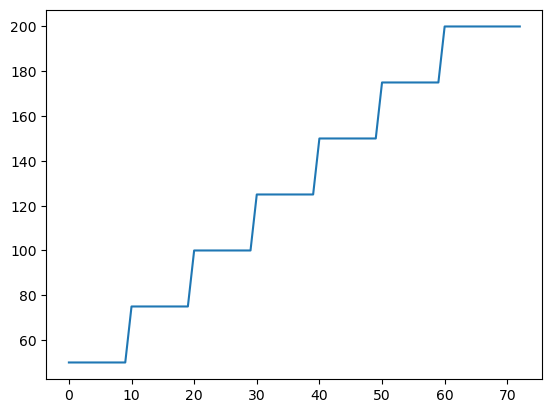

In [3]:
Cp = np.load('traj_det_max.npy')
print(Cp.T)
plt.plot(Time, Cp)
z_0=50.

## 2) States

We describe the dynamics of the conventional and renewable producers.

In [4]:
# Conventional

C_min = 0.
C_max = 70.

t_beta = 0.429 # in tonCO2/MWh

theta = 37.94 * 0.88 - t_beta * z_0  #0.88 is the conversion of euros to GBP
stdC = 12.53 * 0.88
k = 0.5
delta = stdC * np.sqrt(2. * k / theta)

dC = delta * np.sqrt(theta * dt)
n_1 = int(np.ceil((C_max - C_min) / dC))

E_1 = np.linspace(C_min, C_max, num = n_1 + 1)
E_1 = np.reshape(E_1, (E_1.shape[0], 1))
dC = E_1[1, 0] - E_1[0, 0]

m0 = gamma.pdf(E_1, a = 2*theta*k/(delta**2), scale = delta**2/(2*k))
m0 = m0/np.sum(m0)

# Renewable

R_min = 0.3
R_max = 0.6

bartheta= 0.4261
stdR = 0.0443   
bark = 0.5
bardelta = stdR * np.sqrt(2. * bark / (bartheta * (1 - bartheta) - stdR**2))

dR = bardelta * np.sqrt(bartheta * (1 - bartheta) * dt)
n_2 = int(np.ceil((R_max - R_min) / dR))

E_2 = np.linspace(R_min, R_max, num = n_2 + 1)
E_2 = np.reshape(E_2, (E_2.shape[0], 1))
dR = E_2[1, 0] - E_2[0, 0]

barm0 = beta.pdf(E_2, a = 2*bark*bartheta/(bardelta**2), b = 2*bark*(1-bartheta)/(bardelta**2))
barm0 = barm0/np.sum(barm0)

The following functions define the transition kernel of the conventional producer.

In [5]:
# Dynamics conventional

def b(x):
    return k * (theta - x)

def sigma(x):
    return delta * x**(1/2)

def pi_B(x, X):
    if np.allclose(x, E_1[0, 0]):
        if np.allclose(X, E_1[1, 0]):
            P = 1.
        else:
            P = 0.
    elif np.allclose(x, E_1[-1, 0]):
        if np.allclose(X, E_1[-2, 0]):
            P = 1.
        else:
            P = 0.
    else:
        if np.allclose(X, x + dC): 
            P = (sigma(x)**2/2 + dC*np.maximum(b(x), 0))/(sigma(x)**2 + dC*np.abs(b(x)))
        elif np.allclose(X, x - dC): 
            P = (sigma(x)**2/2 - dC*np.minimum(b(x), 0))/(sigma(x)**2 + dC*np.abs(b(x)))
        else:
            P = 0.
    return P   

The following functions define the transition kernel of the renewable producer.

In [6]:
# Dynamics renewable

def bar_b(x):
    return bark*(bartheta-x)

def bar_sigma(x):
    return bardelta*(x*(1-x))**(1/2)

def pi_R(x, X):
    if np.allclose(x, E_2[0, 0]):
        if np.allclose(X, E_2[1, 0]):
            P = 1.
        else:
            P = 0.
    elif np.allclose(x, E_2[-1, 0]):
        if np.allclose(X, E_2[-2, 0]):
            P = 1.
        else:
            P = 0.
    else:
        if np.allclose(X, x + dR): 
            P = (bar_sigma(x)**2/2 + dR*np.maximum(bar_b(x), 0))/(bar_sigma(x)**2 + dR*np.abs(bar_b(x)))
        elif np.allclose(X, x - dR): 
            P = (bar_sigma(x)**2/2 - dR*np.minimum(bar_b(x), 0))/(bar_sigma(x)**2 + dR*np.abs(bar_b(x)))
        else:
            P = 0.
    return P   

## 3) Constraints

We generate a linear constraint of the form $Ax=b$ for each producer, where $x=(\mu, m)^T$.

In [7]:
len_mu_C = Time.shape[0]*E_1.shape[0]
print(len_mu_C)

1022


In [8]:
len_mu_R = Time.shape[0]*E_2.shape[0]
print(len_mu_R)

1095


In [9]:
%%time 
# A_mu

A_mu_C = []

for n0 in range(Time.shape[0]):
    for j in range(E_1.shape[0]): 
        L = [np.zeros((1, E_1.shape[0])) for n in range(Time.shape[0])]
        B = np.zeros((1, E_1.shape[0]))
        B[0, j] = 1.
        L[n0] = B
        A_mu_C.append(np.concatenate(L, axis = 1))
                
A_mu_C = np.concatenate(A_mu_C, axis = 0)

A_mu_C = csr_matrix(A_mu_C)

scipy.sparse.save_npz('matrices/A_mu_C', A_mu_C)

Wall time: 118 ms


In [10]:
A_mu_C = scipy.sparse.load_npz('matrices/A_mu_C.npz')

In [11]:
%%time 

A_m_0_C = []

for n0 in range(Time.shape[0]):
    for j in range(E_1.shape[0]): 
        L = [np.zeros((1, E_1.shape[0])) for n in range(Time.shape[0]-1)]
        if n0<N:
            B = np.zeros((1, E_1.shape[0]))
            B[0, j] = -1.
            L[n0] = B
        A_m_0_C.append(np.concatenate(L, axis = 1))
                    
A_m_0_C = np.concatenate(A_m_0_C, axis = 0)

A_m_0_C = csr_matrix(A_m_0_C)

scipy.sparse.save_npz('matrices/A_m_0_C', A_m_0_C)

Wall time: 129 ms


In [12]:
A_m_0_C = scipy.sparse.load_npz('matrices/A_m_0_C.npz')

To accelerate the computation of the transition kernel integral, we sum only over all possible previous states.

In [13]:
def past_B(X_index):
    if (X_index > 0) and (X_index < E_1.shape[0]-1):
        return [X_index - 1, X_index + 1]
    elif X_index == 0:
        return [1]
    else:
        return [E_1.shape[0]-2]

In [14]:
def past_R(X_index):
    if (X_index > 0) and (X_index < E_2.shape[0]-1):
        return [X_index - 1, X_index + 1]
    elif X_index == 0:
        return [1]
    else:
        return [E_2.shape[0]-2]

In [15]:
%%time

A_m_C = []

for n0 in range(Time.shape[0]):
    for j in range(E_1.shape[0]): 
        L = [np.zeros((1, E_1.shape[0])) for n in range(Time.shape[0]-1)]
        if n0 > 0:
            B = np.zeros((1, E_1.shape[0]))
            for j1 in past_B(j):
                B[0, j1] = pi_B(E_1[j1, 0], E_1[j, 0])
            L[n0-1] = B
        A_m_C.append(np.concatenate(L, axis = 1))

            
A_m_C = np.concatenate(A_m_C, axis = 0)  

A_m_C = csr_matrix(A_m_C)

scipy.sparse.save_npz('matrices/A_m_C', A_m_C)

Wall time: 385 ms


In [16]:
A_m_C = scipy.sparse.load_npz('matrices/A_m_C.npz')

In [17]:
A_eq_C = hstack((A_mu_C, -(A_m_0_C + A_m_C)))

A_eq_C = csr_matrix(A_eq_C)

scipy.sparse.save_npz('matrices/A_eq_C', A_eq_C)

In [18]:
b_eq_C = []

for n0 in range(Time.shape[0]):
    for j in range(E_1.shape[0]): 
        if n0 == 0:
            b_eq_C.append(m0[j, :])
        else:
            b_eq_C.append(np.array([0.]))
                    
b_eq_C = np.concatenate(b_eq_C, axis = 0)

b_eq_C = b_eq_C.reshape((b_eq_C.shape[0], 1))

b_eq_C = csr_matrix(b_eq_C)

scipy.sparse.save_npz('matrices/b_eq_C', b_eq_C)


In [19]:
b_eq_C = scipy.sparse.load_npz('matrices/b_eq_C.npz')

b_eq_C = b_eq_C.toarray()

In [20]:
%%time 
# A_mu

A_mu_R = []

for n0 in range(Time.shape[0]):
    for j in range(E_2.shape[0]): 
        L = [np.zeros((1, E_2.shape[0])) for n in range(Time.shape[0])]
        B = np.zeros((1, E_2.shape[0]))
        B[0, j] = 1.
        L[n0] = B
        A_mu_R.append(np.concatenate(L, axis = 1))
                
A_mu_R = np.concatenate(A_mu_R, axis = 0)

A_mu_R = csr_matrix(A_mu_R)

scipy.sparse.save_npz('matrices/A_mu_R', A_mu_R)

Wall time: 140 ms


In [21]:
A_mu_R = scipy.sparse.load_npz('matrices/A_mu_R.npz')

In [22]:
%%time 

A_m_0_R = []

for n0 in range(Time.shape[0]):
    for j in range(E_2.shape[0]): 
        L = [np.zeros((1, E_2.shape[0])) for n in range(Time.shape[0]-1)]
        if n0<N:
            B = np.zeros((1, E_2.shape[0]))
            B[0, j] = -1.
            L[n0] = B
        A_m_0_R.append(np.concatenate(L, axis = 1))
                    
A_m_0_R = np.concatenate(A_m_0_R, axis = 0)

A_m_0_R = csr_matrix(A_m_0_R)

scipy.sparse.save_npz('matrices/A_m_0_R', A_m_0_R)

Wall time: 151 ms


In [23]:
A_m_0_R = scipy.sparse.load_npz('matrices/A_m_0_R.npz')

In [24]:
%%time

A_m_R = []

for n0 in range(Time.shape[0]):
    for j in range(E_2.shape[0]): 
        L = [np.zeros((1, E_2.shape[0])) for n in range(Time.shape[0]-1)]
        if n0>0:
            B = np.zeros((1, E_2.shape[0]))
            for j1 in past_R(j):
                B[0, j1] = pi_R(E_2[j1, 0], E_2[j, 0])
            L[n0-1] = B
        A_m_R.append(np.concatenate(L, axis = 1))
                    
A_m_R = np.concatenate(A_m_R, axis = 0)  

A_m_R = csr_matrix(A_m_R)

scipy.sparse.save_npz('matrices/A_m_R', A_m_R)

Wall time: 414 ms


In [25]:
A_m_R = scipy.sparse.load_npz('matrices/A_m_R.npz')

In [26]:
A_eq_R = hstack((A_mu_R, -(A_m_0_R + A_m_R)))

A_eq_R = csr_matrix(A_eq_R)

scipy.sparse.save_npz('matrices/A_eq_R', A_eq_R)

In [27]:
b_eq_R = []

for n0 in range(Time.shape[0]):
    for j in range(E_2.shape[0]): 
        if n0 == 0:
            b_eq_R.append(barm0[j, :])
        else:
            b_eq_R.append(np.array([0.]))
                    
b_eq_R = np.concatenate(b_eq_R, axis = 0)

b_eq_R = b_eq_R.reshape((b_eq_R.shape[0], 1))

b_eq_R = csr_matrix(b_eq_R)

scipy.sparse.save_npz('matrices/b_eq_R', b_eq_R)

In [28]:
b_eq_R = scipy.sparse.load_npz('matrices/b_eq_R.npz')

b_eq_R = b_eq_R.toarray()

## 4) Reward functions

We create the reward functions for both types of producers.

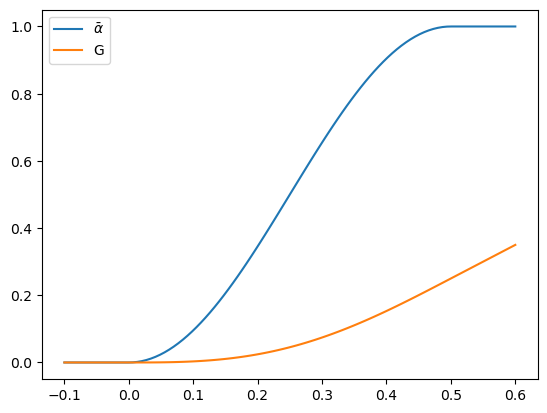

In [5]:
## Bidding function

c_max = 0.5

def bar_alpha(x):
    return (x > c_max) + 1/2*(1 + np.sin(-np.pi/2 + np.pi/c_max*x))*(0 <= x <= c_max)

bar_alpha = np.vectorize(bar_alpha)
x0 = np.linspace(-0.1, 0.6, 100)
plt.plot(x0, bar_alpha(x0), label=r"$\bar \alpha$")

## Gain function

def Gain(x):
    return (x-c_max/2)*(x > c_max) + 1/2*(x-c_max/np.pi*np.cos(-np.pi/2 + np.pi/c_max*x))*(0 <= x <= c_max)

Gain = np.vectorize(Gain)
plt.plot(x0, Gain(x0), label = "G")
plt.legend();

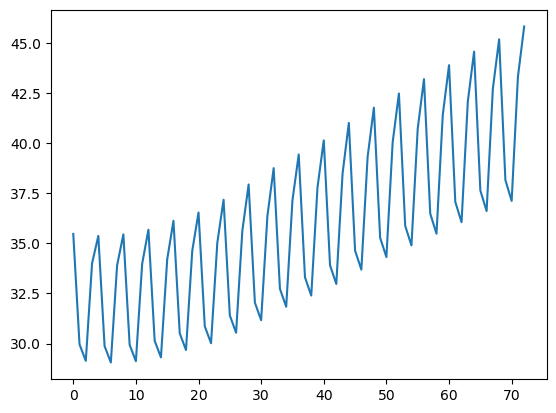

In [6]:
# Demand

beta_factor = 0.015

D = pd.read_excel("Demand_array.xlsx", decimal=',', header=None)
D = D.to_numpy()
D = D.reshape(-1)

sc = np.array([1.10352635, 0.93209028, 0.90656527, 1.05781809])
Lambda = np.tile(sc, int(T))
Lambda = np.append(Lambda, sc[0])

# Adjusting for seasonal cycle

d = np.zeros(73)
for i in range(int(T)): 
    d[i*4:(i+1)*4] = D[i]  
d[-1] = D[-1]

r_d = 1.2875630406414182 # peak / offpeak demand ratio
c_p = 65./168. # peak hours
c_o = 1. - c_p

bar_c_p = r_d/(c_p*r_d+c_o)
bar_c_o = 1/(c_p*r_d+c_o)

plt.plot(np.arange(d.shape[0]), Lambda*d);

In [31]:
# Capacities, cap price and baseline conventional supply

I_C = 35.9
I_R_b = 35.6
I_R = 47.

p_max = 150.

def S_b(x):
    return 12.1/p_max*x

In [32]:
# Costs and rates

rho = 0.086

kappa_C = 30.
K_C = 0.
gamma_C = np.log(2.)/30.

K_R = 1377.
kappa_R = 0.0125 * 1377.
gamma_R = np.log(2.)/10.

convcoef = 24.*365.25/1000. # GBP/MWh = convcoef GBP/kWyr

In [33]:
# Transition matrix of R to compute E[R_n]

Q = np.zeros((E_2.shape[0], E_2.shape[0]))

for i in range(E_2.shape[0]):
    for j in range(E_2.shape[0]):
        Q[i, j] = pi_R(E_2[i], E_2[j])

mean_R = []

for n in range(Time.shape[0]):
    Q_n = matrix_power(Q, n)
    mean_R_n = np.matmul(np.matmul(barm0.T, Q_n), E_2)
    mean_R.append(mean_R_n)

In [34]:
def S_c(m):
    def Supply_C(z, p):
        return I_C * np.sum(bar_alpha(p - E_1 - t_beta*z)*m) + S_b(p)
    return Supply_C

def S_r(n, bar_m):
    return (I_R_b + I_R) * mean_R[n] - I_R * np.sum(E_2 * bar_m)

In [35]:
def bar_P(n, z, d, m, bar_m):
    Supply_R = S_r(n, bar_m)
    Supply_C = S_c(m)
    if d - Supply_R <= 0:
        p_star = 0
    elif d - Supply_R - Supply_C(z, p_max) > 0:
        p_star = p_max
    else:
        def res_demand(p):
            return d - Supply_R - Supply_C(z, p)
        p_star = root_scalar(res_demand, bracket = [0, p_max], x0 = p_max/2).root
    return p_star

In [36]:
def f(n, x, z, p_1, p_2):
    return np.exp(-rho*n*dt)*(convcoef*(c_p*Gain(p_1-x-t_beta*z) + c_o*Gain(p_2-x-t_beta*z))-kappa_C)*dt

In [37]:
def g(n):
    return K_C * np.exp(-(gamma_C + rho) * n * dt)

In [38]:
def bar_f(n, x, p_1, p_2):
    return -np.exp(-rho*n*dt)*(convcoef*(c_p*p_1 + c_o*p_2)*x - kappa_R)*dt

In [39]:
def bar_g(n):
    return K_R * np.exp(-rho*T -gamma_R*(T- n * dt)) - K_R*np.exp(-rho*n*dt)

In [40]:
G = []

for n in range(Time.shape[0]):
    for j in range(E_1.shape[0]): 
        G.append(np.array([[g(n)]]))
                    
G = np.concatenate(G, axis = 0)

G = G.reshape((G.shape[0], 1))

np.save('matrices/G', G)

In [41]:
G = np.load('matrices/G.npy')

In [42]:
def F_generator(m, bar_m):

    F = []
    
    bar_F = []

    for n in range(Time.shape[0]-1):
        p_price = bar_P(n, Cp[n, 0], Lambda[n]*bar_c_p*(d[n] + beta_factor * (Cp[n, 0]-z_0)),
                        m[[n], :].T, bar_m[[n], :].T)

        op_price = bar_P(n, Cp[n, 0], Lambda[n]*bar_c_o*(d[n] + beta_factor * (Cp[n, 0]-z_0)), 
                         m[[n], :].T, bar_m[[n], :].T)

        for j in range(E_1.shape[0]): 
            F.append(np.array([[f(n, E_1[j, 0], Cp[n, 0], p_price, op_price)]]))

        for j1 in range(E_2.shape[0]): 
            bar_F.append(np.array([[bar_f(n, E_2[j1, 0], p_price, op_price)]]))
                        
    F = np.concatenate(F, axis = 0)
    
    F = F.reshape((F.shape[0], 1))
                    
    bar_F = np.concatenate(bar_F, axis = 0)
    
    bar_F = bar_F.reshape((bar_F.shape[0], 1))

    return F, bar_F

In [43]:
bar_G = []

for n in range(Time.shape[0]):
    for j in range(E_2.shape[0]): 
        bar_G.append(np.array([[bar_g(n)]]))
                                            
bar_G = np.concatenate(bar_G, axis = 0)

bar_G = bar_G.reshape((bar_G.shape[0], 1))

np.save('matrices/bar_G', bar_G)

In [44]:
bar_G = np.load('matrices/bar_G.npy')

## 5) Interior point algorithm

To solve the linear programming problems we use Gurobi's LP solver (a free academic license is available). 

In [45]:
def best_response_C(F):
    reward = np.concatenate([G, F], axis = 0)
    
    model = gp.Model()
    model.Params.LogToConsole = 0
    rows, cols = len(b_eq_C), len(reward)
    variables = []
    for j in range(cols):
        variables.append(model.addVar(lb=0, ub=1, obj=reward[j, 0]))
    model.update()
    
    # iterate over the rows of S adding each row into the model
    for i in range(rows):
        start = A_eq_C.indptr[i]
        end = A_eq_C.indptr[i+1]
        variables_row = [variables[j] for j in A_eq_C.indices[start:end]]
        coeff = A_eq_C.data[start:end]
        expr = gp.LinExpr(coeff, variables_row)
        model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=b_eq_C[i, 0])
    
    model.update()
    model.ModelSense = -1
    model.optimize()
    
    sol = [variables[j].X for j in range(cols)]

    mu_raw = sol[:len_mu_C]
    m_raw = sol[len_mu_C:]
    mu_raw = np.array(mu_raw)
    m_raw = np.array(m_raw)
            
    mu_new = mu_raw.reshape((Time.shape[0], E_1.shape[0]))
        
    m_new = m_raw.reshape((Time.shape[0]-1, E_1.shape[0]))
                        
    return mu_new, m_new, model.ObjVal

In [46]:
def best_response_R(bar_F):
    reward = np.concatenate([bar_G, bar_F], axis = 0)
    
    model = gp.Model()
    model.Params.LogToConsole = 0
    rows, cols = len(b_eq_R), len(reward)
    variables = []
    for j in range(cols):
        variables.append(model.addVar(lb=0, ub=1, obj=reward[j, 0]))
    model.update()
    
    # iterate over the rows of S adding each row into the model
    for i in range(rows):
        start = A_eq_R.indptr[i]
        end = A_eq_R.indptr[i+1]
        variables_row = [variables[j] for j in A_eq_R.indices[start:end]]
        coeff = A_eq_R.data[start:end]
        expr = gp.LinExpr(coeff, variables_row)
        model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=b_eq_R[i, 0])
    
    model.update()
    model.ModelSense = -1
    model.optimize()
    
    sol = [variables[j].X for j in range(cols)]
    
    mu_raw = sol[:len_mu_R]
    m_raw = sol[len_mu_R:]
    mu_raw = np.array(mu_raw)
    m_raw = np.array(m_raw)
    
    mu_new = mu_raw.reshape((Time.shape[0], E_2.shape[0]))
        
    m_new = m_raw.reshape((Time.shape[0]-1, E_2.shape[0]))
                        
    return mu_new, m_new, model.ObjVal

## II. Fictitious Play

The following function implements the Fictitious Play procedure where the best responses are obtained by solving LP problems.

In [47]:
def fictitious_play(guess_mu_0, guess_m_0, guess_mu_bar_0, guess_m_bar_0, tol, N_iter):
    """
    Argument: 
    guess_mu_0 -- initial guess for mu conventional
    guess_m_0 -- initial guess for m conventional
    guess_mu_bar_0 -- initial guess for mu renewable
    guess_m_bar_0 -- initial guess for m renewable
    tol -- error tolerance
    N_iter -- Maximum number of iterations
    
    Returns:
    List_C -- List containing guess_mu, guess_m, mu, m
    List_R -- List containing guess_mu_bar, guess_m_bar, mu_bar, m_bar
    List_error -- List containing explo_C, explo_R, eps_array
    """
    F, bar_F = F_generator(guess_m_0, guess_m_bar_0)
            
    guess_mu, guess_m, maximum = best_response_C(F)
            
    guess_mu_bar, guess_m_bar, maximum_bar = best_response_R(bar_F)
    
    eps = tol + 1
    
    eps_list = []
    eps_C_list = []
    eps_R_list = []
    
    explo_C = []
    explo_R = []
    
    n_iter = 1
    
    message_1 = "Iteration: {:4d}; Exploitability Conventional:  {:.2f}; Exploitability Renewable: {:.2f}"
    message_2 = "Rel error Conventional:  {:.4f}; Rel error Renewable: {:.4f}; Maximum: {:.4f}"
    
    while (eps > tol) and (n_iter <= N_iter):
        
        F, bar_F = F_generator(guess_m, guess_m_bar)
            
        mu, m, maximum = best_response_C(F)
            
        mu_bar, m_bar, maximum_bar = best_response_R(bar_F)
            
        # Exploitability Conventional            
            
        guess_mu_raw = []
        for n in range(Time.shape[0]):
            for j in range(E_1.shape[0]): 
                guess_mu_raw.append(guess_mu[n, j])

        guess_mu_raw = np.array(guess_mu_raw)
        guess_mu_raw = guess_mu_raw.reshape((guess_mu_raw.shape[0], 1)) 
                        
        guess_m_raw = []
        for n in range(Time.shape[0]-1):
            for j in range(E_1.shape[0]): 
                guess_m_raw.append(guess_m[n, j])

        guess_m_raw = np.array(guess_m_raw)
        guess_m_raw = guess_m_raw.reshape((guess_m_raw.shape[0], 1))

        guess_value = np.matmul(G.T, guess_mu_raw) + np.matmul(F.T, guess_m_raw)
        guess_value = guess_value[0, 0]        

        exploitability = maximum - guess_value
        explo_C.append(exploitability)
        eps_n_C = exploitability / np.abs(guess_value)            
            
        # Exploitability Renewable

        guess_mu_bar_raw = []
        for n in range(Time.shape[0]):
            for j in range(E_2.shape[0]): 
                guess_mu_bar_raw.append(guess_mu_bar[n, j])
                
        guess_mu_bar_raw = np.array(guess_mu_bar_raw)
        guess_mu_bar_raw = guess_mu_bar_raw.reshape((guess_mu_bar_raw.shape[0], 1))
                        
        guess_m_bar_raw = []
        for n in range(Time.shape[0]-1):
            for j in range(E_2.shape[0]): 
                guess_m_bar_raw.append(guess_m_bar[n, j])
                                
        guess_m_bar_raw = np.array(guess_m_bar_raw)
        guess_m_bar_raw = guess_m_bar_raw.reshape((guess_m_bar_raw.shape[0], 1))

        guess_bar_value = np.matmul(bar_G.T, guess_mu_bar_raw) + np.matmul(bar_F.T, guess_m_bar_raw)
        guess_bar_value = guess_bar_value[0, 0]


        exploitability_bar = maximum_bar - guess_bar_value
        explo_R.append(exploitability_bar)
        eps_n_R = exploitability_bar / np.abs(guess_bar_value)
            
        # Relative errors
        eps_n = max(eps_n_C, eps_n_R)
        eps_list.append(eps_n)
        eps_C_list.append(eps_n_C)
        eps_R_list.append(eps_n_R)

        # NEW GUESS
        guess_mu = n_iter/(n_iter+1)*guess_mu + 1/(n_iter+1)*mu
        guess_mu_bar = n_iter/(n_iter+1)*guess_mu_bar + 1/(n_iter+1)*mu_bar
        guess_m = n_iter/(n_iter+1)*guess_m + 1/(n_iter+1)*m
        guess_m_bar = n_iter/(n_iter+1)*guess_m_bar + 1/(n_iter+1)*m_bar

        print(message_1.format(n_iter, exploitability, exploitability_bar))
        print(message_2.format(eps_n_C, eps_n_R, eps_n))
            
        
        eps = eps_n
        n_iter += 1
        
    eps_array = np.array(eps_list)
    eps_C_array = np.array(eps_C_list)
    eps_R_array = np.array(eps_R_list)
    explo_C = np.array(explo_C)
    explo_R = np.array(explo_R)
    
        
    List_C = [guess_mu, guess_m, mu, m]
    List_R = [guess_mu_bar, guess_m_bar, mu_bar, m_bar]
    
    List_error = [explo_C, explo_R, eps_array]

    return List_C, List_R, List_error

## III. Results

We give a preliminary initial guess and apply the LPFP algorithm to our model.

In [48]:
# Preliminary initial guess

# Conventional
guess_mu_0 = []
for n in range(Time.shape[0]):
    A = np.ones((E_1.shape[0]))
    guess_mu_0.append(A/np.sum(A))
guess_mu_0 = np.array(guess_mu_0)
    
guess_m_0 = []
for n in range(Time.shape[0]-1):
    A = np.ones((E_1.shape[0]))
    guess_m_0.append(A/np.sum(A))
guess_m_0 = np.array(guess_m_0)
    
# Renewable

guess_mu_bar_0 = []
for n in range(Time.shape[0]):
    A = np.ones((E_2.shape[0]))
    guess_mu_bar_0.append(A/np.sum(A))
guess_mu_bar_0 = np.array(guess_mu_bar_0)
    
guess_m_bar_0 = []
for n in range(Time.shape[0]-1):
    A = np.ones((E_2.shape[0]))
    guess_m_bar_0.append(A/np.sum(A))
guess_m_bar_0 = np.array(guess_m_bar_0)

In [49]:
%%time

tol = .00005
N_iter = 500

L_C, L_R, L_E = fictitious_play(guess_mu_0, guess_m_0, guess_mu_bar_0, guess_m_bar_0, tol, N_iter)

Set parameter TokenServer to value "PYGMALION"
Iteration:    1; Exploitability Conventional:  266.98; Exploitability Renewable: 795.29
Rel error Conventional:  1.0000; Rel error Renewable: 0.6159; Maximum: 1.0000
Iteration:    2; Exploitability Conventional:  40.44; Exploitability Renewable: 246.05
Rel error Conventional:  1.0555; Rel error Renewable: 0.1715; Maximum: 1.0555
Iteration:    3; Exploitability Conventional:  86.95; Exploitability Renewable: 107.32
Rel error Conventional:  2.1834; Rel error Renewable: 0.0778; Maximum: 2.1834
Iteration:    4; Exploitability Conventional:  52.13; Exploitability Renewable: 97.97
Rel error Conventional:  1.2152; Rel error Renewable: 0.0784; Maximum: 1.2152
Iteration:    5; Exploitability Conventional:  30.99; Exploitability Renewable: 61.67
Rel error Conventional:  1.8308; Rel error Renewable: 0.0468; Maximum: 1.8308
Iteration:    6; Exploitability Conventional:  30.80; Exploitability Renewable: 44.01
Rel error Conventional:  1.5851; Rel error 

Iteration:   52; Exploitability Conventional:  2.22; Exploitability Renewable: 3.63
Rel error Conventional:  0.1232; Rel error Renewable: 0.0029; Maximum: 0.1232
Iteration:   53; Exploitability Conventional:  2.17; Exploitability Renewable: 3.55
Rel error Conventional:  0.1181; Rel error Renewable: 0.0029; Maximum: 0.1181
Iteration:   54; Exploitability Conventional:  2.13; Exploitability Renewable: 3.48
Rel error Conventional:  0.1158; Rel error Renewable: 0.0028; Maximum: 0.1158
Iteration:   55; Exploitability Conventional:  2.09; Exploitability Renewable: 3.44
Rel error Conventional:  0.1129; Rel error Renewable: 0.0028; Maximum: 0.1129
Iteration:   56; Exploitability Conventional:  2.06; Exploitability Renewable: 3.37
Rel error Conventional:  0.1124; Rel error Renewable: 0.0027; Maximum: 0.1124
Iteration:   57; Exploitability Conventional:  2.03; Exploitability Renewable: 3.30
Rel error Conventional:  0.1082; Rel error Renewable: 0.0027; Maximum: 0.1082
Iteration:   58; Exploitabil

Iteration:  103; Exploitability Conventional:  1.12; Exploitability Renewable: 1.82
Rel error Conventional:  0.0573; Rel error Renewable: 0.0015; Maximum: 0.0573
Iteration:  104; Exploitability Conventional:  1.11; Exploitability Renewable: 1.80
Rel error Conventional:  0.0567; Rel error Renewable: 0.0014; Maximum: 0.0567
Iteration:  105; Exploitability Conventional:  1.10; Exploitability Renewable: 1.79
Rel error Conventional:  0.0560; Rel error Renewable: 0.0014; Maximum: 0.0560
Iteration:  106; Exploitability Conventional:  1.09; Exploitability Renewable: 1.78
Rel error Conventional:  0.0561; Rel error Renewable: 0.0014; Maximum: 0.0561
Iteration:  107; Exploitability Conventional:  1.08; Exploitability Renewable: 1.75
Rel error Conventional:  0.0548; Rel error Renewable: 0.0014; Maximum: 0.0548
Iteration:  108; Exploitability Conventional:  1.07; Exploitability Renewable: 1.74
Rel error Conventional:  0.0547; Rel error Renewable: 0.0014; Maximum: 0.0547
Iteration:  109; Exploitabil

Iteration:  154; Exploitability Conventional:  0.75; Exploitability Renewable: 1.22
Rel error Conventional:  0.0380; Rel error Renewable: 0.0010; Maximum: 0.0380
Iteration:  155; Exploitability Conventional:  0.74; Exploitability Renewable: 1.21
Rel error Conventional:  0.0373; Rel error Renewable: 0.0010; Maximum: 0.0373
Iteration:  156; Exploitability Conventional:  0.74; Exploitability Renewable: 1.20
Rel error Conventional:  0.0370; Rel error Renewable: 0.0010; Maximum: 0.0370
Iteration:  157; Exploitability Conventional:  0.73; Exploitability Renewable: 1.19
Rel error Conventional:  0.0368; Rel error Renewable: 0.0010; Maximum: 0.0368
Iteration:  158; Exploitability Conventional:  0.73; Exploitability Renewable: 1.20
Rel error Conventional:  0.0369; Rel error Renewable: 0.0010; Maximum: 0.0369
Iteration:  159; Exploitability Conventional:  0.72; Exploitability Renewable: 1.18
Rel error Conventional:  0.0362; Rel error Renewable: 0.0009; Maximum: 0.0362
Iteration:  160; Exploitabil

Iteration:  205; Exploitability Conventional:  0.56; Exploitability Renewable: 0.92
Rel error Conventional:  0.0282; Rel error Renewable: 0.0007; Maximum: 0.0282
Iteration:  206; Exploitability Conventional:  0.56; Exploitability Renewable: 0.91
Rel error Conventional:  0.0278; Rel error Renewable: 0.0007; Maximum: 0.0278
Iteration:  207; Exploitability Conventional:  0.56; Exploitability Renewable: 0.91
Rel error Conventional:  0.0279; Rel error Renewable: 0.0007; Maximum: 0.0279
Iteration:  208; Exploitability Conventional:  0.55; Exploitability Renewable: 0.90
Rel error Conventional:  0.0275; Rel error Renewable: 0.0007; Maximum: 0.0275
Iteration:  209; Exploitability Conventional:  0.55; Exploitability Renewable: 0.90
Rel error Conventional:  0.0274; Rel error Renewable: 0.0007; Maximum: 0.0274
Iteration:  210; Exploitability Conventional:  0.55; Exploitability Renewable: 0.89
Rel error Conventional:  0.0272; Rel error Renewable: 0.0007; Maximum: 0.0272
Iteration:  211; Exploitabil

Iteration:  256; Exploitability Conventional:  0.45; Exploitability Renewable: 0.73
Rel error Conventional:  0.0222; Rel error Renewable: 0.0006; Maximum: 0.0222
Iteration:  257; Exploitability Conventional:  0.45; Exploitability Renewable: 0.73
Rel error Conventional:  0.0221; Rel error Renewable: 0.0006; Maximum: 0.0221
Iteration:  258; Exploitability Conventional:  0.45; Exploitability Renewable: 0.72
Rel error Conventional:  0.0220; Rel error Renewable: 0.0006; Maximum: 0.0220
Iteration:  259; Exploitability Conventional:  0.44; Exploitability Renewable: 0.72
Rel error Conventional:  0.0220; Rel error Renewable: 0.0006; Maximum: 0.0220
Iteration:  260; Exploitability Conventional:  0.44; Exploitability Renewable: 0.72
Rel error Conventional:  0.0219; Rel error Renewable: 0.0006; Maximum: 0.0219
Iteration:  261; Exploitability Conventional:  0.44; Exploitability Renewable: 0.72
Rel error Conventional:  0.0220; Rel error Renewable: 0.0006; Maximum: 0.0220
Iteration:  262; Exploitabil

Iteration:  307; Exploitability Conventional:  0.38; Exploitability Renewable: 0.61
Rel error Conventional:  0.0185; Rel error Renewable: 0.0005; Maximum: 0.0185
Iteration:  308; Exploitability Conventional:  0.37; Exploitability Renewable: 0.61
Rel error Conventional:  0.0185; Rel error Renewable: 0.0005; Maximum: 0.0185
Iteration:  309; Exploitability Conventional:  0.37; Exploitability Renewable: 0.61
Rel error Conventional:  0.0183; Rel error Renewable: 0.0005; Maximum: 0.0183
Iteration:  310; Exploitability Conventional:  0.37; Exploitability Renewable: 0.61
Rel error Conventional:  0.0185; Rel error Renewable: 0.0005; Maximum: 0.0185
Iteration:  311; Exploitability Conventional:  0.37; Exploitability Renewable: 0.60
Rel error Conventional:  0.0182; Rel error Renewable: 0.0005; Maximum: 0.0182
Iteration:  312; Exploitability Conventional:  0.37; Exploitability Renewable: 0.60
Rel error Conventional:  0.0182; Rel error Renewable: 0.0005; Maximum: 0.0182
Iteration:  313; Exploitabil

Iteration:  358; Exploitability Conventional:  0.32; Exploitability Renewable: 0.52
Rel error Conventional:  0.0158; Rel error Renewable: 0.0004; Maximum: 0.0158
Iteration:  359; Exploitability Conventional:  0.32; Exploitability Renewable: 0.52
Rel error Conventional:  0.0158; Rel error Renewable: 0.0004; Maximum: 0.0158
Iteration:  360; Exploitability Conventional:  0.32; Exploitability Renewable: 0.52
Rel error Conventional:  0.0157; Rel error Renewable: 0.0004; Maximum: 0.0157
Iteration:  361; Exploitability Conventional:  0.32; Exploitability Renewable: 0.52
Rel error Conventional:  0.0157; Rel error Renewable: 0.0004; Maximum: 0.0157
Iteration:  362; Exploitability Conventional:  0.32; Exploitability Renewable: 0.52
Rel error Conventional:  0.0156; Rel error Renewable: 0.0004; Maximum: 0.0156
Iteration:  363; Exploitability Conventional:  0.32; Exploitability Renewable: 0.52
Rel error Conventional:  0.0157; Rel error Renewable: 0.0004; Maximum: 0.0157
Iteration:  364; Exploitabil

Iteration:  409; Exploitability Conventional:  0.28; Exploitability Renewable: 0.46
Rel error Conventional:  0.0138; Rel error Renewable: 0.0004; Maximum: 0.0138
Iteration:  410; Exploitability Conventional:  0.28; Exploitability Renewable: 0.46
Rel error Conventional:  0.0138; Rel error Renewable: 0.0004; Maximum: 0.0138
Iteration:  411; Exploitability Conventional:  0.28; Exploitability Renewable: 0.46
Rel error Conventional:  0.0139; Rel error Renewable: 0.0004; Maximum: 0.0139
Iteration:  412; Exploitability Conventional:  0.28; Exploitability Renewable: 0.45
Rel error Conventional:  0.0137; Rel error Renewable: 0.0004; Maximum: 0.0137
Iteration:  413; Exploitability Conventional:  0.28; Exploitability Renewable: 0.45
Rel error Conventional:  0.0137; Rel error Renewable: 0.0004; Maximum: 0.0137
Iteration:  414; Exploitability Conventional:  0.28; Exploitability Renewable: 0.45
Rel error Conventional:  0.0136; Rel error Renewable: 0.0004; Maximum: 0.0136
Iteration:  415; Exploitabil

Iteration:  460; Exploitability Conventional:  0.25; Exploitability Renewable: 0.41
Rel error Conventional:  0.0124; Rel error Renewable: 0.0003; Maximum: 0.0124
Iteration:  461; Exploitability Conventional:  0.25; Exploitability Renewable: 0.41
Rel error Conventional:  0.0122; Rel error Renewable: 0.0003; Maximum: 0.0122
Iteration:  462; Exploitability Conventional:  0.25; Exploitability Renewable: 0.41
Rel error Conventional:  0.0122; Rel error Renewable: 0.0003; Maximum: 0.0122
Iteration:  463; Exploitability Conventional:  0.25; Exploitability Renewable: 0.41
Rel error Conventional:  0.0122; Rel error Renewable: 0.0003; Maximum: 0.0122
Iteration:  464; Exploitability Conventional:  0.25; Exploitability Renewable: 0.41
Rel error Conventional:  0.0122; Rel error Renewable: 0.0003; Maximum: 0.0122
Iteration:  465; Exploitability Conventional:  0.25; Exploitability Renewable: 0.40
Rel error Conventional:  0.0121; Rel error Renewable: 0.0003; Maximum: 0.0121
Iteration:  466; Exploitabil

In [50]:
guess_mu, guess_m, mu, m = L_C
guess_mu_bar, guess_m_bar, mu_bar, m_bar = L_R
explo_C, explo_R, eps_array = L_E

In [51]:
def save_results(L_C, L_R, L_E):
    np.save('results/L_C_det', L_C, allow_pickle = True)
    np.save('results/L_R_det', L_R, allow_pickle = True)
    np.save('results/L_E_det', L_E, allow_pickle = True)

In [52]:
#save_results(L_C, L_R, L_E)

In [53]:
def load_results():
    L_C = np.load('results/L_C_det.npy', allow_pickle = True)
    L_R = np.load('results/L_R_det.npy', allow_pickle = True)
    L_E = np.load('results/L_E_det.npy', allow_pickle = True)
    return L_C, L_R, L_E

In [54]:
L_C, L_R, L_E = load_results()